In [ ]:
!pip install pytorch-ignite
!pip install ptan
!pip install tensorboardX
!pip install ignite
import ptan
import tensorboardX
import ptan
import gym
import gym.spaces
from gym.utils import seeding
from gym.envs.registration import EnvSpec
import enum
import numpy as np
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorboard
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': (18, 10)})
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

print('Tensorflow version: {}'.format(tf.__version__))

In [ ]:
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.7.0 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 9),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [ ]:
from lib import environ, data, common, models, validation

In [ ]:
# # 1nd Edition
# %cd '/content/gdrive/MyDrive/course/Data Analysis/HW4'
# !git clone 'https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On'
# %cd 'Deep-Reinforcement-Learning-Hands-On/Chapter08/'
# !tar zxvf 'data/ch08-small-quotes.tgz'  -C 'data'

In [ ]:
# ## 2nd Edition
# !git clone 'https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On-Second-Edition'
# %cd 'Deep-Reinforcement-Learning-Hands-On-Second-Edition/Chapter08/'
# !tar zxvf 'data/ch08-small-quotes.tgz'  -C 'data'

In [ ]:
df_train = pd.read_csv('data/YNDX_150101_151231.csv')
df_val = pd.read_csv('data/YNDX_160101_161231.csv')
df_t = df_train[:5000]
df_v =   df_val[:5000]
df_t.to_csv('train.csv')
df_v.to_csv('valid.csv')
!mv *.csv data/
df_t.shape, df_v.shape

((5000, 7), (5000, 7))

In [ ]:
!python train_model.py --data 'data/train.csv'  --val 'data/valid.csv' -r 'first_run'
# !python train_model.py --data 'data/YNDX_150101_151231.csv'  --val 'data/YNDX_160101_161231.csv' -r 'first_run'

# DDPG with threshold

In [ ]:
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lib import environ, data, common, models, validation
env = environ.StocksEnv({"YNDX": data.load_relative('data/train.csv')})
# env = environ.StocksEnv({"YNDX": data.load_relative('data/YNDX_150101_151231.csv')})
from math import floor
import torch
import torch.autograd
import torch.optim as optim
import torch.nn as nn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd
from torch.autograd import Variable

class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        """Params state and actions are torch tensors"""
        if len(action.shape) < 2:
            action = np.expand_dims(action, axis=1)
            action = torch.from_numpy(action)
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x


class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
    def forward(self, state):
        """Param state is a torch tensor"""
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.sigmoid(self.linear3(x))
        return x

import gym
from collections import deque
import random

# Ornstein-Ulhenbeck Process
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15,
                 max_sigma=0.3, min_sigma=0.3, decay_period=15000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = 1
        self.low          = 0
        self.high         = 1
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)


# https://github.com/openai/gym/blob/master/gym/core.py
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def _action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def _reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)


class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)


class DDPGagent:
    def __init__(self, env, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=50000):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = 1
        self.gamma = gamma
        self.tau = tau

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions)
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)

        # Training
        self.memory = Memory(max_memory_size)
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)

    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        return action

    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)

        # Critic loss
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()

        # update networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # update target networks
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau
                                    + target_param.data
                                    * (1.0 - self.tau))

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau
                                    + target_param.data
                                    * (1.0 - self.tau))


In [ ]:
env = environ.StocksEnv({"YNDX": data.load_relative('data/train.csv')})
# env = environ.StocksEnv({"YNDX": data.load_relative('/data/YNDX_150101_151231.csv')})
# env = environ.StocksEnv({"YNDX": data.load_relative('data/YNDX_150101_151231.csv')})
agent = DDPGagent(env)
noise = OUNoise(1, decay_period=15000)
batch_size = 64
rewards = []
avg_rewards = []
n_episodes = 15000
all_steps = []
for episode in range(n_episodes):
    state = env.reset()
    noise.reset()
    episode_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        action = agent.get_action(state)
        action = noise.get_action(action, steps)

        if action > 0.66:
            action = 2
        elif action > 0.33:
            action = 1
        else:
            action = 0

        new_state, reward, done, _ = env.step(action)
        agent.memory.push(state, action, reward, new_state, done)
        if len(agent.memory) > batch_size:
            agent.update(batch_size)

        state = new_state
        episode_reward += reward
        # print(reward)

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-100:]))
    all_steps.append(steps)

    if episode % 10 == 0:
        sys.stdout.write("episode: {}, reward: {}, average _reward: {} , average steps:{}\n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-100:]), all_steps[-1]))




    if episode % 100 == 0:
    ########################################### SAVE RESULTS ####################################
    ########################################### SAVE RESULTS ####################################
        import os
        model_str = f'n_episodes={n_episodes}, batch_size={batch_size}'
        directory = f'results/DDPG_T/{model_str}'
        os.makedirs(directory, exist_ok=True)
        os.chdir(directory)
        np.savetxt('rewards.txt', rewards)
        np.savetxt('avg_rewards.txt', avg_rewards)
    ########################################### SAVE RESULTS ####################################
    ########################################### SAVE RESULTS ####################################
        plt.plot(avg_rewards, label='Average Rewards', c='r')
        # plt.plot(avg_rewards, label='Average Rewards', c='r')
        plt.plot()
        plt.title('DDPG')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.savefig('Average Rewards.png', pad_inches=0, bbox_inches='tight')
        plt.show()



        plt.plot(rewards, label='Rewards', c='b')
        plt.plot(avg_rewards, label='Average Rewards', c='r')
        plt.plot()
        plt.title('DDPG')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.savefig('DDPG_T.png', pad_inches=0, bbox_inches='tight')
        plt.legend()
        plt.show()


        plt.plot(all_steps, label='Length of Episodes', c='b')
        plt.plot()
        plt.title('Length of Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Steps')
        plt.legend()
        plt.savefig('Length of Episodes.png', pad_inches=0, bbox_inches='tight')
        plt.show()

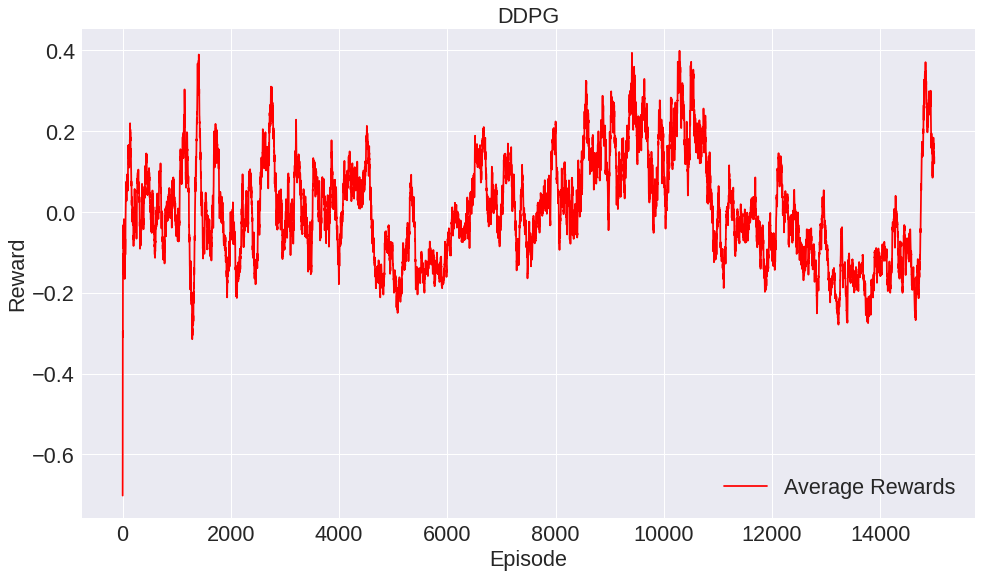

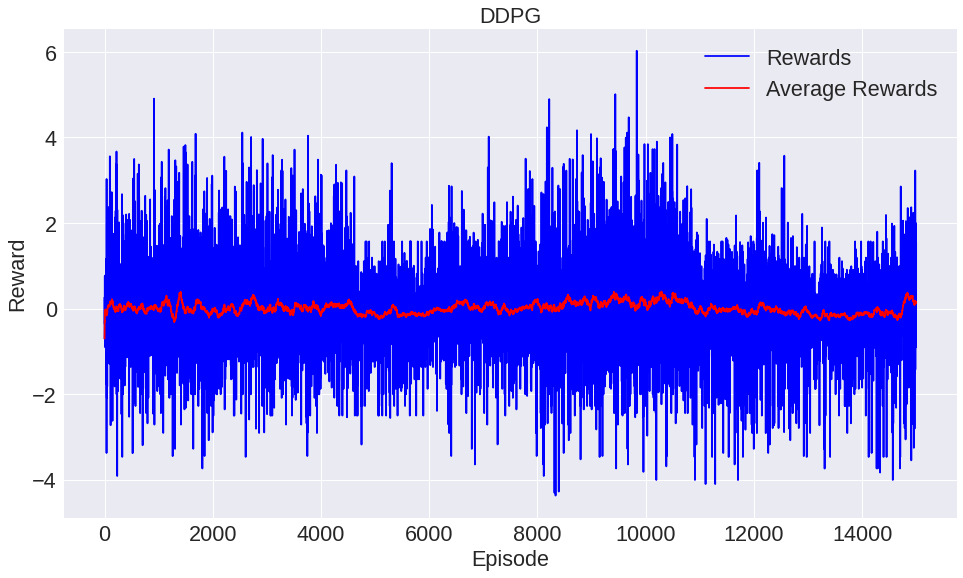

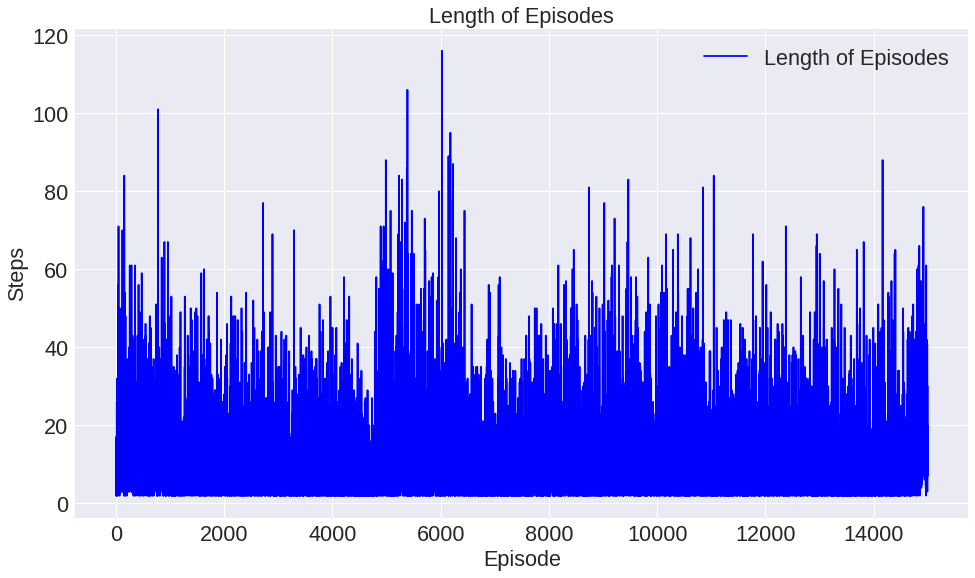

In [ ]:
########################################### SAVE RESULTS ####################################
########################################### SAVE RESULTS ####################################
model_str = f'n_episodes={n_episodes}, batch_size={batch_size}'
directory = f'results/DDPG_T/{model_str}'
os.makedirs(directory, exist_ok=True)
os.chdir(directory)
np.savetxt('rewards.txt', rewards)
np.savetxt('avg_rewards.txt', avg_rewards)
########################################### SAVE RESULTS ####################################
########################################### SAVE RESULTS ####################################
plt.plot(avg_rewards, label='Average Rewards', c='r')
# plt.plot(avg_rewards, label='Average Rewards', c='r')
plt.plot()
plt.title('DDPG')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.savefig('/content/Average Rewards.png', pad_inches=0, bbox_inches='tight')
plt.show()



plt.plot(rewards, label='Rewards', c='b')
plt.plot(avg_rewards, label='Average Rewards', c='r')
plt.plot()
plt.title('DDPG')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.savefig('/content/DDPG_T.png', pad_inches=0, bbox_inches='tight')
plt.legend()
plt.show()


plt.plot(all_steps, label='Length of Episodes', c='b')
plt.plot()
plt.title('Length of Episodes')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.legend()
plt.savefig('/content/Length of Episodes.png', pad_inches=0, bbox_inches='tight')
plt.show()

# A2C

In [ ]:
import sys
import torch
import gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

# hyperparameters
hidden_size = 256
learning_rate = 3e-4

# Constants
GAMMA = 0.99
num_steps = 300


In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)

    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)

        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

        return value, policy_dist


In [ ]:
def a2c(env):
    num_inputs = env.observation_space.shape[0]
    num_outputs = env.action_space.n

    actor_critic = ActorCritic(num_inputs, num_outputs, hidden_size)
    ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

    global all_lengths
    all_lengths = []
    average_lengths = []
    global all_rewards
    all_rewards = []
    all_average_rewards = []
    entropy_term = 0

    max_episodes = 300000
    rewards_v = []
    for episode in range(max_episodes):
        log_probs = []
        values = []
        rewards = []
        done = False
        state = env.reset()
        steps = 0

        while not done:
            steps += 1
            value, policy_dist = actor_critic.forward(state)
            # print(policy_dist)
            value = value.detach().numpy()[0,0]
            dist = policy_dist.detach().numpy()

            action = np.random.choice(num_outputs, p=np.squeeze(dist))
            log_prob = torch.log(policy_dist.squeeze(0)[action])
            entropy = -np.sum(np.mean(dist) * np.log(dist))
            new_state, reward, done, _ = env.step(action)

            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            entropy_term += entropy
            state = new_state

            # if done or steps==5000:
            if done:
                Qval, _ = actor_critic.forward(new_state)
                Qval = Qval.detach().numpy()[0,0]
                all_rewards.append(np.sum(rewards)) # np.sum(rewards) == rewards for all steps in a single episode
                                                    # all_rewards == has all rewards for each episode
                avg_reward = np.mean(all_rewards[-100:]) # for each episode we calculate average rewards for 100 last episodes
                all_average_rewards.append(avg_reward)
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-100:]))
                if episode % 100 == 0:
                    sys.stdout.write(f"episode: {episode}, reward: {np.sum(rewards)}, average reward: {avg_reward}\
total length: {steps}, average length: {average_lengths[-1]}\n")
                break

        # compute Q values
        Qvals = np.zeros_like(values)
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + GAMMA * Qval
            Qvals[t] = Qval

        #update actor critic
        values = torch.FloatTensor(values)
        Qvals = torch.FloatTensor(Qvals)
        log_probs = torch.stack(log_probs)

        advantage = Qvals - values
        actor_loss = (-log_probs * advantage).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()
        ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()

        # if episode % 100 == 0:
        #     r = validation_run_a2c(actor_critic)
        #     rewards_v.append(r)

        if episode % 1000 == 0:

        ########################################### SAVE RESULTS ####################################
        ########################################### SAVE RESULTS ####################################
            import os
            model_str = f'n_episodes={max_episodes}, hidden_size={hidden_size}, GAMMA={GAMMA}, len(dataset): {len(df_t)}'
            directory = f'results/A2C/{model_str}'
            os.makedirs(directory, exist_ok=True)
            os.chdir(directory)
            np.savetxt(f'steps_{episode}.txt', np.array(all_lengths))
            np.savetxt(f'all_rewards_{episode}.txt', all_rewards)
            torch.save(actor_critic.state_dict(), directory + '/actor_critic_A2C')
        ########################################### SAVE RESULTS ####################################
        ########################################### SAVE RESULTS ####################################

            x = [i+1 for i in range(len(all_rewards))]
            running_avg = np.zeros(len(all_rewards))
            for i in range(len(running_avg)):
                running_avg[i] = np.mean(all_rewards[max(0, i-100):(i+1)])
            plt.plot(x, running_avg, c='r', label='average reward')
            plt.title('Average Reward')
            plt.xlabel('Episode')
            plt.ylabel('Reward')
            plt.savefig(f'average reward_{episode}', pad_inches=0, bbox_inches='tight')
            plt.show()



            plt.plot(all_rewards, label='Rewards', c='b')
            plt.plot(x, running_avg, c='r', label='average reward')
            plt.title('A2C')
            plt.xlabel('Episodes')
            plt.ylabel('Reward')
            plt.legend()
            plt.savefig(f'A2C_{episode}.png', pad_inches=0, bbox_inches='tight')
            plt.show()

            # # Plot results
            # smoothed_rewards_v = pd.Series.rolling(pd.Series(rewards_v), 10).mean()
            # smoothed_rewards_v = [elem for elem in smoothed_rewards_v]
            # plt.plot(rewards_v, label='Rewards', c='b')
            # plt.plot(smoothed_rewards_v, label='Smooted Rewards', c='r')
            # # plt.plot()
            # plt.title('A2C for Validation')
            # plt.xlabel('Episodes')
            # plt.ylabel('Reward')
            # plt.legend()
            # plt.savefig('A2C for Validation.png', pad_inches=0, bbox_inches='tight')
            # plt.show()

            plt.plot(all_lengths, label='Steps', c='b')
            # plt.plot(average_lengths, label='average_lengths', c='r')
            plt.title('lengths of played episodes')
            plt.xlabel('Episodes')
            plt.ylabel('Steps')
            plt.legend()
            plt.savefig(f'The lengths of played episodes_{episode}.png', pad_inches=0, bbox_inches='tight')
            plt.show()


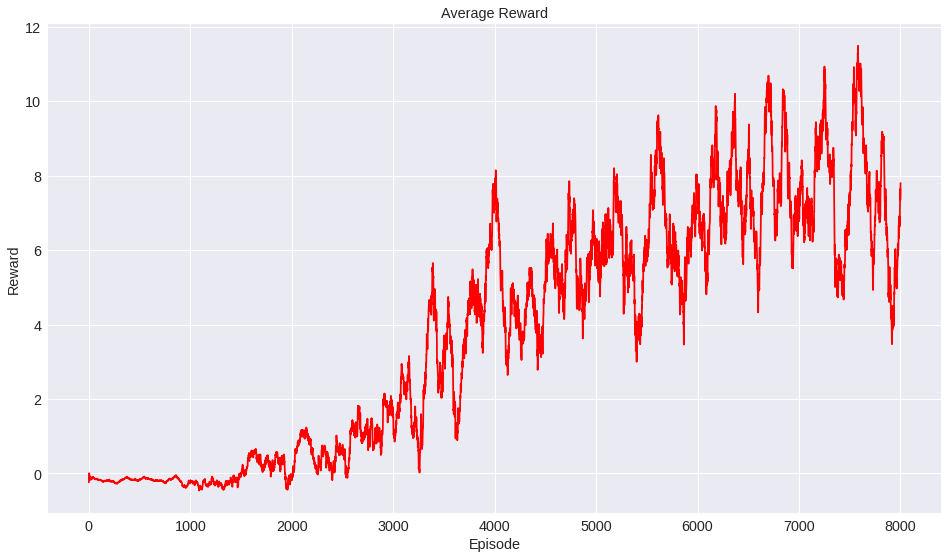

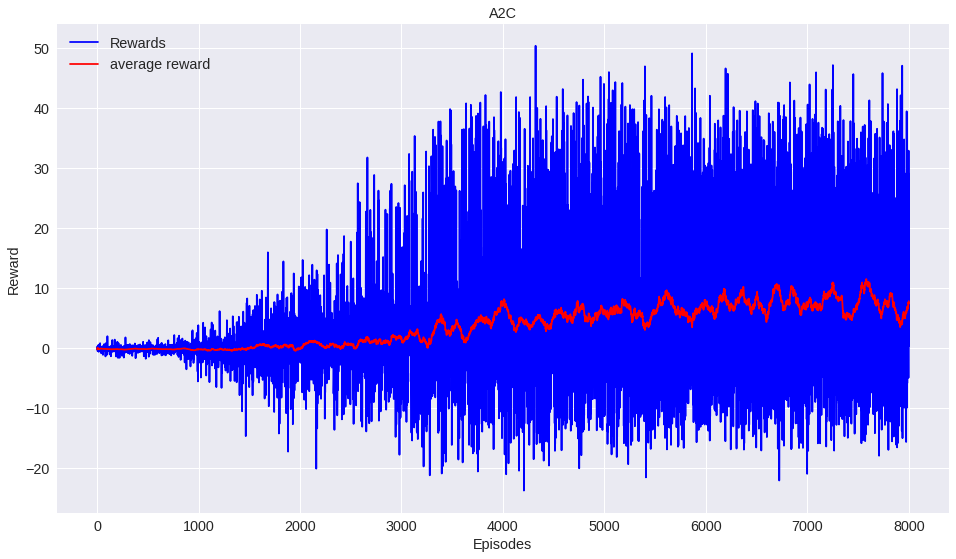

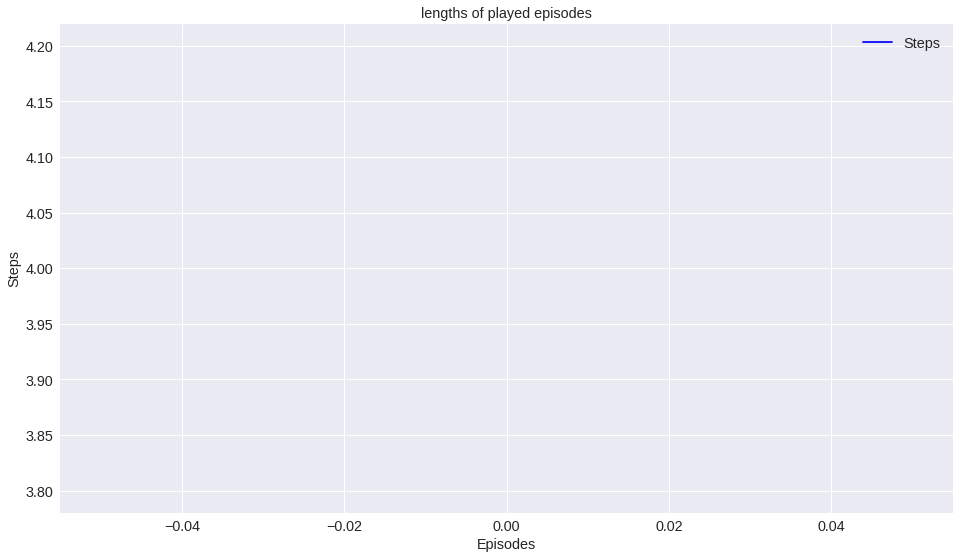

In [ ]:
x = [i+1 for i in range(len(all_rewards))]
# plot_learning_curve(x, all_rewards, directory + '/average reward A2C.png')
running_avg = np.zeros(len(all_rewards))
for i in range(len(running_avg)):
    running_avg[i] = np.mean(all_rewards[max(0, i-100):(i+1)])
plt.plot(x, running_avg, c='r')
plt.title('Average Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.savefig('Average Reward_8000.png', pad_inches=0, bbox_inches='tight')
plt.show()

plt.plot(all_rewards, label='Rewards', c='b')
plt.plot(x, running_avg, c='r', label='average reward')
plt.title('A2C')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend()
# plt.savefig('A2C.png', pad_inches=0, bbox_inches='tight')
plt.legend()
plt.show()


plt.plot(all_lengths, label='Steps', c='b')
# plt.plot(average_lengths, label='average_lengths', c='r')
plt.title('lengths of played episodes')
plt.xlabel('Episodes')
plt.ylabel('Steps')
plt.legend()
# plt.savefig('The lengths of played episodes.png', pad_inches=0, bbox_inches='tight')
plt.show()


# PPO

In [ ]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
            fc1_dims=256, fc2_dims=256, chkpt_dir='results/PPO/'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        self.actor = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1))
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        return dist

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
            chkpt_dir='results/PPO/'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)

        return value

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
                 policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)

    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)

            values = T.tensor(values).to(self.actor.device)
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()

In [ ]:
import gym
import numpy as np

if __name__ == '__main__':
    # env = environ.StocksEnv({"YNDX": data.load_relative('data/train.csv')})
    env = environ.StocksEnv({"YNDX": data.load_relative('data/YNDX_160101_161231.csv')})

    # env_v = environ.StocksEnv({"YNDX": data.load_relative('data/valid.csv')})

    batch_size = 64
    n_epochs = 1
    alpha = 0.0003
    agent = Agent(n_actions=env.action_space.n, batch_size=batch_size,
                    alpha=alpha, n_epochs=n_epochs,
                    input_dims=env.observation_space.shape)

    n_episode = 100000
    all_avg_scores = []

    best_score = env.reward_range[0]
    score_history = []
    rewards = []
    steps = []
    learn_iters = 0
    avg_score = 0
    n_steps = 0

    score_history_v = []

    for i in range(n_episode):
        observation = env.reset()
        done = False
        score = 0
        steps_ = 0

        while not done:
            action, prob, val = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            n_steps += 1
            steps_ += 1
            score += reward
            agent.remember(observation, action, prob, val, reward, done)

        agent.learn()
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])
        all_avg_scores.append(np.mean(score_history[-100:]))
        steps.append(steps_)

        if i % 100 == 0:
            print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
                    'average lengths', np.mean(steps[-100:]))

        if i % 1000 == 0:
            ########################################### SAVE RESULTS ####################################
            ########################################### SAVE RESULTS ####################################
                import os
                model_str = f'n_episode={n_episode}, N={N}, batch_size={batch_size}, n_epochs={n_epochs}, alpha={alpha}'
                directory = f'results/PPO/{model_str}'
                os.makedirs(directory, exist_ok=True)
                os.chdir(directory)
                np.savetxt('score_history.txt', score_history)
                np.savetxt('steps.txt', np.array(steps))
                np.savetxt('all_avg_scores.txt', np.array(all_avg_scores))
                agent.save_models()
            ########################################### SAVE RESULTS ####################################
            ########################################### SAVE RESULTS ####################################


                plt.plot(all_avg_scores, c='r')
                plt.title('Average Reward')
                plt.xlabel('Episode')
                plt.ylabel('Reward')
                plt.savefig(f'average reward{i}.png', pad_inches=0, bbox_inches='tight')
                plt.show()

                plt.plot(score_history, label='rewards', c='b')
                # smoothed_rewards = pd.Series.rolling(pd.Series(score_history), 10).mean()
                # smoothed_rewards = [elem for elem in smoothed_rewards]
                plt.plot(all_avg_scores, label='average reward', c='r')
                plt.title('PPO')
                plt.xlabel('Episodes')
                plt.ylabel('Rewards')
                plt.legend()
                plt.savefig(f'PPO_{i}.png', pad_inches=0, bbox_inches='tight')
                plt.show()

                plt.plot(steps, label='Steps', c='b')
                # plt.plot(average_lengths, label='average_lengths', c='r')
                plt.title('lengths of played episodes')
                plt.xlabel('Episode')
                plt.ylabel('Steps')
                # plt.legend()
                plt.savefig(f'The lengths of played episodes_{i}.png', pad_inches=0, bbox_inches='tight')
                plt.show()

In [ ]:
x = [i+1 for i in range(len(score_history))]
plot_learning_curve(x, score_history, 'PPO.png')
plt.show()

plt.plot(score_history, label='rewards', c='b')
plt.title('PPO')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.savefig('PPO.png', pad_inches=0, bbox_inches='tight')
plt.show()


plt.plot(score_history_v, label='rewards', c='b')
# smoothed_rewards_v = pd.Series.rolling(pd.Series(score_history_v), 10).mean()
# smoothed_rewards_v = [elem for elem in smoothed_rewards_v]
# plt.plot(smoothed_rewards_v, label='smoothed rewards', c='r')
plt.title('PPO for Validation')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.savefig('PPO for Validation.png', pad_inches=0, bbox_inches='tight')
plt.show()


plt.plot(steps, label='Steps', c='b')
# plt.plot(average_lengths, label='average_lengths', c='r')
plt.title('lengths of played episodes')
plt.xlabel('Episode')
plt.ylabel('Steps')
# plt.legend()
plt.savefig('The lengths of played episodes.png', pad_inches=0, bbox_inches='tight')
plt.show()